# Processing Iwasaki FRT
- Ruoyi Jiang
- January 19, 2019
- Step-by-step processing

In [343]:
from matplotlib import pyplot as plt
%matplotlib inline

In [1]:
import os
import subprocess

#### GEX

In [2]:
#link to base directory
gex_dir = "/home/ruoyi/Dropbox/Projects/Iwasaki_FRT/10X/analysis/defaults/gex"

### 10X outs placed by collaborator in guest account home directory

In [3]:
import pandas as pd
import os

from presto.IO import readSeqFile
from presto.Annotation import parseAnnotation, flattenAnnotation
from presto.Defaults import default_delimiter

from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO

#### VDJ

In [12]:
#link to base directory
vdj_dir = "/home/ruoyi/Dropbox/Projects/Iwasaki_FRT/10X/analysis/defaults/vdj"
changeo_dir = "/home/ruoyi/Dropbox/Projects/Iwasaki_FRT/10X/analysis/changeo"

## Run changeo

### Read in annotation, fasta files and concatenate

In [13]:
combined_dict = {}
for sample in os.listdir(vdj_dir):
    annotation_file = os.path.join(vdj_dir, sample, "filtered_contig_annotations.csv")
    sample_vdj_df = pd.read_csv(annotation_file)

    contig_file = os.path.join(vdj_dir, sample, "filtered_contig.fasta")
    contig_iter = SeqIO.parse(contig_file, format = 'fasta')

    contig_dict = {seq.description:seq.seq._data for seq in contig_iter}
    sample_vdj_df['SEQUENCE'] = sample_vdj_df.apply(lambda row: contig_dict[row['contig_id']], axis = 1)

    sample_vdj_df['SAMPLE'] = sample
    combined_dict[sample] = sample_vdj_df

In [14]:
vdj_df = pd.concat(combined_dict, axis = 0)

In [15]:
vdj_df.shape

(20572, 20)

### Convert pandas DF to changeo fasta

In [16]:
conversion_dict = {
    'SEQUENCE': 'SEQUENCE',
    'CREGION': 'c_gene',
    'ID': 'contig_id',
    'CELL': 'barcode',
    'CONSCOUNT': 'reads',
    'DUPCOUNT': 'umis',
    'SAMPLE': 'SAMPLE'
}

inverted_conversion_dict = {v: k for k, v in conversion_dict.items()}

In [22]:
out_type="fasta"
reference_dir = "/home/ruoyi/kleinstein/reference/bulk"

# will make directories here for shazam results
plot_changeo_dir = os.path.join(changeo_dir, "shazam")

In [18]:
# make directories
os.makedirs(plot_changeo_dir, exist_ok=True)
os.makedirs(changeo_dir, exist_ok=True)

In [19]:
# write combined vdj_tab file to fasta files in presto-style
row_dict = vdj_df.T.to_dict()

sample = "combined"
output_file = os.path.join(changeo_dir, sample + '.fasta')
pass_handle = open(output_file, 'w')

for row in row_dict:
    seq_record = SeqRecord(Seq(row_dict[row]['SEQUENCE']))
    out_ann = {inverted_conversion_dict[key]: row_dict[row][key] for key in row_dict[row] \
               if key in inverted_conversion_dict and key != conversion_dict['SEQUENCE']}
    seq_record.id = flattenAnnotation(out_ann, delimiter=default_delimiter)
    seq_record.description = ''
    seq_record.name = ''

    SeqIO.write(seq_record, pass_handle, out_type)

pass_handle.close()

### Run changeo

In [20]:
from changeo.Applications import runIgBLAST

import os
import sys
sys.path.append('/home/ruoyi/Dropbox/hg/pipeline_abseq/api/neptune')
from neptune import detectChimera
from neptune import lightchainCompleteLinkage

import numpy as np

import datetime
import glob
import subprocess
import shlex

In [23]:
print("AssignGenes.py"  + ' ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

runIgBLAST( \
        os.path.join(changeo_dir, sample + ".fasta"), \
        os.path.join(reference_dir, "igblast_db"), \
        loci='ig', \
        organism='mouse', \
        output=os.path.join(changeo_dir, sample + '_igblast.fmt7'),
        format='blast', \
        threads=1, \
        exec='igblastn')

AssignGenes.py 2019-06-07 11:34:40


''

In [24]:
print("MakeDb.py" + ' ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

cmd = [
"MakeDb.py igblast",
"-s", os.path.join(changeo_dir, sample + ".fasta"),
"-i", os.path.join(changeo_dir, sample + "_igblast.fmt7"),
"-r", " ".join(glob.glob(os.path.join(reference_dir, "imgt/mouse/vdj/*.fasta"))),
"--scores",
"--regions",
"--outdir", os.path.join(changeo_dir)
]

result = subprocess.Popen(shlex.split(' '.join(cmd)), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output = result.communicate()
print(output[0].decode("utf-8") + "\nERROR: \n" + output[1].decode("utf-8"))

MakeDb.py 2019-06-07 11:44:48
       START> MakeDB
     ALIGNER> IgBLAST
ALIGNER_FILE> combined_igblast.fmt7
    SEQ_FILE> combined.fasta
     PARTIAL> False
      SCORES> True
     REGIONS> True
     ASIS_ID> False
  ASIS_CALLS> False

PROGRESS> 11:44:49 |Done                | 0.0 min

PROGRESS> 11:45:05 |####################| 100% (20,572) 0.3 min

OUTPUT> combined_igblast_db-pass.tab
  PASS> 12997
  FAIL> 7575
   END> MakeDb


ERROR: 



### Light chain cloning

In [310]:
# # Code copied from neptune, private repository, uncomment to run

# def lightchainCompleteLinkage(cell_series, group_series):
#     """
#     Performs complete linkage of V_GENE, J_GENE columns

#     Arguments:
#       cell_series (pandas series): pandas series of CELL labels.
#       group_series (pandas series): pandas series of grouping labels (e.g. VJJL).

#     Returns:
#       assign_dict (dict): dictionary assigning cells to VJJL clusters corrected with complete linkage.
#     """
#     # assign initial clusters
#     lc_dict = {}
#     for cell, group in zip(cell_series, group_series):
#         try:    
#             lc_dict[group].append(cell)
#         except KeyError:
#             lc_dict[group] = [cell]

#     # link clusters (ON^2)
#     cluster_dict = {}
#     for i, gene in enumerate(lc_dict.keys()):
#         for cluster in cluster_dict:
#             if any(i in lc_dict[gene] for i in cluster_dict[cluster]):
#                 cluster_dict[cluster] = cluster_dict[cluster] + lc_dict[gene]
#                 break
#         cluster_dict[i] = lc_dict[gene]

#     # invert assignments and make assignments
#     assign_dict = {cell:k for k,v in cluster_dict.items() for cell in set(v)}

#     return assign_dict

In [311]:
DF = pd.read_table(os.path.join(changeo_dir, sample + "_igblast_db-pass.tab"), \
        dtype=object)

# Length filter so will not affect cloning
DF = DF.loc[DF.apply(lambda row: len(row['SEQUENCE_VDJ']) > 100, axis = 1)]

# Isolate heavy and light chain DF
heavy_df = DF.loc[DF.apply(lambda row: 'IGH' in row['CREGION'], axis = 1)]
light_df = DF.loc[DF.apply(lambda row: not 'IGH' in row['CREGION'], axis = 1)]

# Duplicate heavy chain filter
heavy_df = heavy_df.drop_duplicates('CELL', keep=False)

# Set group
light_df['GROUP'] = light_df\
    .apply(lambda row: row['V_CALL'].split(',')[0].split('*')[0] + ',' + 
           row['J_CALL'].split(',')[0].split('*')[0],
           axis = 1)

# Assignment dictionary
assign_dict = lightchainCompleteLinkage(light_df['CELL'], light_df['GROUP'])
    
# Make assignments
heavy_df['LIGHT_CLONE'] = heavy_df.apply(lambda row: assign_dict.get(row['CELL']) if assign_dict.get(row['CELL']) is not None else -1, axis = 1)

# export
out_df_name = os.path.join(changeo_dir, sample + "_igblast_db-pass_light-pass.tab")
heavy_df.to_csv(out_df_name, sep ="\t", index = False)

/usr/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.
/usr/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [312]:
print("ParseDb.py" + ' ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

cmd = [
"~/.local/bin/ParseDb.py select",
"-d", os.path.join(changeo_dir, sample + "_igblast_db-pass_light-pass.tab"),
"-f V_CALL J_CALL CREGION -u \"IGH\" --logic all --regex",
"--outname", sample + "-hc",
"--outdir", os.path.join(changeo_dir)
]

#result = subprocess.Popen(shlex.split(' '.join(cmd)), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
result = subprocess.Popen(' '.join(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)

#output = result.communicate()
#print(output[0].decode("utf-8") + "\nERROR: \n" + output[1].decode("utf-8"))

ParseDb.py 2019-06-07 18:38:34


In [313]:
# print("ShazamV1.8_Distance.R" + ' ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

# cmd = [
# "/home/ruoyi/Dropbox/hg/immcantation/pipelines/ShazamV1.8_Distance.R",
# "-n", sample,
# "--subsample 1000",
# "-d", os.path.join(changeo_dir, sample + "-hc_parse-select.tab"),
# "-o", plot_changeo_dir
# ]

# result = subprocess.Popen(shlex.split(' '.join(cmd)), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
# output = result.communicate()
# print(output[0].decode("utf-8") + "\nERROR: \n" + output[1].decode("utf-8"))

# threshold = np.mean(pd.read_table(os.path.join(plot_changeo_dir, sample + "_threshold-values.tab"),\
#                                   sep = '\t')['threshold'])

### Use threshold identified by manual inspection

In [314]:
threshold = 0.1

In [315]:
print("DefineClones.py" + ' ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

cmd = [
"DefineClones.py",
"-d", os.path.join(changeo_dir, sample + "-hc_parse-select.tab"),
"--model ham --norm len --mode gene --act first --dist", str(threshold),"--gf","LIGHT_CLONE",
"--outdir", os.path.join(changeo_dir)
]

result = subprocess.Popen(shlex.split(' '.join(cmd)), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output = result.communicate()
print(output[0].decode("utf-8") + "\nERROR: \n" + output[1].decode("utf-8"))

DefineClones.py 2019-06-07 18:38:35
       START> DefineClones
        FILE> combined-hc_parse-select.tab
   SEQ_FIELD> JUNCTION
     V_FIELD> V_CALL
     J_FIELD> J_CALL
 MAX_MISSING> 0
GROUP_FIELDS> LIGHT_CLONE
      ACTION> first
        MODE> gene
    DISTANCE> 0.1
     LINKAGE> single
       MODEL> ham
        NORM> len
         SYM> avg
       NPROC> 8

PROGRESS> [Grouping sequences] 18:38:38 (3317) 0.0 min

PROGRESS> [Assigning clones] 18:38:40 |####################| 100% (3,317) 0.1 min

 OUTPUT> combined-hc_parse-select_clone-pass.tab
 CLONES> 3036
RECORDS> 3317
   PASS> 3317
   FAIL> 0
    END> DefineClones


ERROR: 



In [316]:
print("Length Filter, N Filter" + ' ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

# Input
DF = pd.read_table(os.path.join(changeo_dir, sample + "-hc_parse-select_clone-pass.tab"),\
                   dtype=object)


Length Filter, N Filter 2019-06-07 18:38:40


/usr/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


In [317]:
# SEQUENCE_VDJ length filter >200
DF = DF.loc[DF.apply(lambda row: len(row['SEQUENCE_INPUT']) > 200, axis = 1),:]

# Remove 10% Ns
n_percent_threshold = 0.10
DF = DF.loc[DF.apply(lambda row: n_percent_threshold*len(row['SEQUENCE_INPUT']) > row['SEQUENCE_INPUT'].count('N'), axis = 1),:]

# Output
out_df_name = os.path.join(changeo_dir, sample + "-hc_parse-select_clone-pass_filter-pass.tab")
DF.to_csv(out_df_name, sep ="\t", index = False)

In [318]:
germline_input = os.path.join(changeo_dir, sample \
                              + "-hc_parse-select_clone-pass_filter-pass.tab")
v_call_field = "V_CALL"

cmd = [
    "CreateGermlines.py",
    "-d", germline_input,
    "-r", os.path.join(reference_dir, "imgt/mouse/vdj"), 
    "-g dmask --sf SEQUENCE_IMGT --vf", v_call_field, "--cloned", "--log",os.path.join(changeo_dir, "log.log"),
    "--outdir", os.path.join(changeo_dir)
]
result = subprocess.Popen(shlex.split(' '.join(cmd)), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output = result.communicate()
print(output[0].decode("utf-8") + "\nERROR: \n" + output[1].decode("utf-8"))

      START> CreateGermlines
       FILE> combined-hc_parse-select_clone-pass_filter-pass.tab
 GERM_TYPES> dmask
  SEQ_FIELD> SEQUENCE_IMGT
    V_FIELD> V_CALL
    D_FIELD> D_CALL
    J_FIELD> J_CALL
     CLONED> True
CLONE_FIELD> CLONE

PROGRESS> 18:38:42 |Done                | 0.0 min

PROGRESS> 18:38:43 |####################| 100% (3,317) 0.0 min

 OUTPUT> combined-hc_parse-select_clone-pass_filter-pass_germ-pass.tab
RECORDS> 3317
   PASS> 3317
   FAIL> 0
    END> CreateGermlines


ERROR: 



In [319]:
# Code copied from neptune, private repository, uncomment to run

# # define window and mismatch size
# default_window_size = 10
# default_max_mismatch_size = 6

# # only assess when germline and sequence are ACGT e.g. not N - . or None (i.e. different lengths)
# default_nt_set = ['A', 'C', 'G', 'T']

# def detectChimera(germline, \
#                   sequence, \
#                   window = default_window_size, \
#                   max_mismatch = default_max_mismatch_size, \
#                   nt_set = default_nt_set):
#     """
#     Detects the presence of chimeras using sliding window analysis

#     Arguments:
#       germline (str): string corresponding to germline sequence.
#       sequence (str): string corresponding to observed sequence.
#       window (int): integer corresponding to the window size for scanning.
#       max_mismatch (int): integer corresponding to the maximum count of mutations in window size.
#       nt_set (iterable): set of nt's used for scanning across germline and observed sequences.

#     Returns:
#       bool: presence or absence of chimera in sequence.
#     """
    
#     #generate a bool vector of mismatches 
#     mismatch_vec = [g != s for g,s in zip(germline, sequence) if g in nt_set and s in nt_set]
    
#     #bool if window found containing more than max_mismatches
#     return not any(sum(mismatch_vec[i:(i + window)]) > max_mismatch for i in range(len(mismatch_vec) - window + 1))

In [320]:
print("Filter Chimeras" + ' ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

DF = pd.read_table(os.path.join(changeo_dir, \
        sample + "-hc_parse-select_clone-pass_filter-pass_germ-pass.tab"), \
        dtype=object)

# Remove chimeras
DF = DF.loc[DF.apply(lambda row: detectChimera(row['GERMLINE_IMGT_D_MASK'], row['SEQUENCE_IMGT'], max_mismatch = 5, window = 10), axis = 1),:]

# Output
out_df_name = os.path.join(changeo_dir, sample + "-hc_parse-select_clone-pass_filter-pass_germ-pass_filter-pass.tab")
DF.to_csv(out_df_name, sep ="\t", index = False)

Filter Chimeras 2019-06-07 18:38:43


/usr/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [321]:
DF = pd.read_table(os.path.join(changeo_dir, \
        sample + "-hc_parse-select_clone-pass_filter-pass_germ-pass_filter-pass.tab"), \
        dtype=object)

/usr/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [322]:
DF.shape

(3315, 61)

In [323]:
DF.groupby('SAMPLE').agg('count')[['SEQUENCE_ID']]

SEQUENCE_ID
SAMPLE              
SP1_BCR         1666
SP2_BCR         1470
V1_BCR           130
V2_BCR            49

In [324]:
DF.groupby(['SAMPLE', 'CLONE']).agg('count').groupby('SAMPLE').agg('count')[['SEQUENCE_ID']]

SEQUENCE_ID
SAMPLE              
SP1_BCR         1471
SP2_BCR         1398
V1_BCR           127
V2_BCR            49

# Read in DF for analysis

In [326]:
DF = pd.read_table(os.path.join(changeo_dir, \
        sample + "-hc_parse-select_clone-pass_filter-pass_germ-pass_filter-pass.tab"), \
        dtype=object)

/usr/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


#### Neptune code for reference

In [334]:
# # compute pairwise overlaps, returns a dataframe
# def calculateOverlap(DF, index = 'CLONE', columns = ['SAMPLE'], dist_func = braycurtis):
    
#     # pivot the table
#     DF_PRE = DF[[index] + columns]
#     DF_PRE['COUNT'] = 1
#     DF_POST = DF_PRE.pivot_table(index = index, columns = columns, values = 'COUNT').fillna(0)
#     DF_POST = DF_POST/DF_POST.sum()
    
#     # compute pairwise distances
#     dist_dict = {}
#     for column1 in DF_POST.columns:
#         dist_dict[column1] = {}
#         for column2 in DF_POST.columns: 
#             dist_dict[column1][column2] = dist_func(np.array(DF_POST[column1]), np.array(DF_POST[column2]))

#     return pd.DataFrame(dist_dict)


# # compute pairwise overlaps, returns a dataframe
# def countOverlap(DF, index = 'CLONE', columns = ['SAMPLE'], collapse=True):
    
#     # define function for counting overlap
#     if collapse:
#         dist_func = (lambda x0, x1: sum([a > 0 and b > 0 for a,b in zip(x0,x1)]))
#     else:
#         dist_func = (lambda x0, x1: sum([a+b if a > 0 and b > 0 else 0 for a,b in zip(x0,x1)]))
    
#     # pivot the table
#     DF_PRE = DF[[index] + columns]
#     DF_PRE['COUNT'] = 1
#     DF_POST = DF_PRE.pivot_table(index = index, columns = columns, values = 'COUNT', aggfunc = np.sum).fillna(0)
    
#     # compute pairwise distances
#     dist_dict = {}
#     for column1 in DF_POST.columns:
#         dist_dict[column1] = {}
#         for column2 in DF_POST.columns: 
#             dist_dict[column1][column2] = dist_func(np.array(DF_POST[column1]), np.array(DF_POST[column2]))

#     return pd.DataFrame(dist_dict)

## Format V_CALL column

In [335]:
DF['V_GENE'] = DF.apply(lambda row: row['V_CALL'].split(',')[0].split('*')[0], axis = 1)

# Overlap Analysis

In [336]:
import seaborn as sns

In [337]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import braycurtis

In [338]:
import sys
sys.path.append('/home/ruoyi/Dropbox/hg/pipeline_abseq/api/neptune')
import neptune

In [339]:
#dist_func = (lambda x0, x1: cosine_similarity(x0,x1)[0][0])
#dist_func = braycurtis
#dist_func = (lambda x0, x1: 1 - braycurtis(1*(x0 > 0), 1*(x1 > 0)))
#dist_func = (lambda x0, x1: cosine_similarity(x0 > 0, x1 > 0)[0][0])
#dist_func = np.dot

In [340]:
transfer_dir = "/home/ruoyi/Dropbox/Projects/Iwasaki_FRT/10X/analysis/notebooks/overlap"

## Sequence overlap

In [341]:
overlap_df = neptune.countOverlap(DF, index = 'SEQUENCE_IMGT', columns = ['SAMPLE'])

/home/ruoyi/Dropbox/hg/pipeline_abseq/api/neptune/neptune.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DF_PRE['COUNT'] = 1


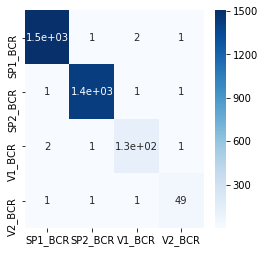

In [344]:
plt.figure(figsize = (4,4))
sns.heatmap(overlap_df, annot=True, cmap="Blues")

## Clone overlap

In [345]:
overlap_df = neptune.countOverlap(DF, index = 'CLONE', columns = ['SAMPLE'])

/home/ruoyi/Dropbox/hg/pipeline_abseq/api/neptune/neptune.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DF_PRE['COUNT'] = 1


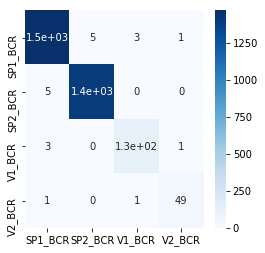

In [346]:
plt.figure(figsize = (4,4))
sns.heatmap(overlap_df, annot=True, cmap="Blues")

In [347]:
overlap_df = neptune.countOverlap(DF, index = 'CLONE', columns = ['SAMPLE'], collapse = False)

/home/ruoyi/Dropbox/hg/pipeline_abseq/api/neptune/neptune.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DF_PRE['COUNT'] = 1


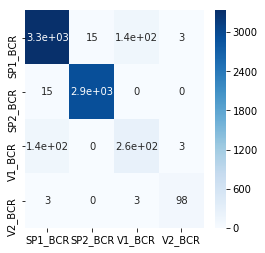

In [348]:
plt.figure(figsize = (4,4))
sns.heatmap(overlap_df, annot=True, cmap="Blues")

In [349]:
dist_func = (lambda x0, x1: cosine_similarity(x0,x1)[0][0])

In [350]:
overlap_df = neptune.calculateOverlap(DF, index = 'CLONE', columns = ['SAMPLE'], dist_func = dist_func)

/home/ruoyi/Dropbox/hg/pipeline_abseq/api/neptune/neptune.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DF_PRE['COUNT'] = 1
/usr/lib64/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lib64/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  Deprecat

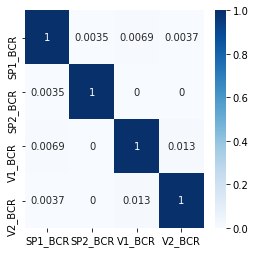

In [351]:
plt.figure(figsize = (4,4))
sns.heatmap(overlap_df, annot=True, cmap="Blues")